# Import & Setup Data

In [1]:
import pandas as pd

In [2]:
# Define the mapping from wait descriptions to numerical values
wait_mapping = {
    'Around 1 hour': 1,
    'Over 1 hour': 2,
    'Over 2 hours': 3,
    'Over 3 hours': 4,
    'Over 4 hours': 5,
    'Over 5 hours': 6,
    'Over 6 hours': 7,
    'Over 7 hours': 8,
    'Over 8 hours': 9
}

In [3]:
# Load the data
df = pd.read_csv('../data/raw_data.csv', parse_dates=['Timestamp'], index_col=['Timestamp'])

In [4]:
# Convert wait times using the mapping
for column in df.columns:  # Skip the first column (Timestamp)
    df[column] = df[column].map(wait_mapping)

In [5]:
df.head()

,Alice Ho Miu Ling Nethersole Hospital,Caritas Medical Centre,Kwong Wah Hospital,North District Hospital,North Lantau Hospital,Princess Margaret Hospital,Pok Oi Hospital,Prince of Wales Hospital,Pamela Youde Nethersole Eastern Hospital,Queen Elizabeth Hospital,Queen Mary Hospital,Ruttonjee Hospital,St John Hospital,Tseung Kwan O Hospital,Tuen Mun Hospital,Tin Shui Wai Hospital,United Christian Hospital,Yan Chai Hospital
Timestamp,,,,,,,,,,,,,,,,,,
2023-12-31 23:45:00,4,4,9,9,5,9,6,5,5,3,6,4,1,6,9,4,8,7
2024-01-01 00:01:00,4,5,9,9,5,9,6,6,5,3,6,5,1,6,9,4,8,7
2024-01-01 00:15:00,4,5,9,9,5,9,6,5,5,2,6,5,1,6,9,4,8,7
2024-01-01 00:30:00,4,7,9,9,5,9,6,5,5,3,6,5,1,6,9,4,8,7
2024-01-01 00:45:00,4,6,9,9,5,9,6,5,5,3,6,5,1,6,9,4,8,7


In [6]:
# Initialize an empty DataFrame for the reformatted data
reformatted_data = pd.DataFrame(columns=['timestamp', 'hospital', 'previous wait', 'current wait'])

In [7]:
# Iterate over each hospital to create the required format
for column in df.columns[1:]:  # Skip the Timestamp column
    # Create a temporary DataFrame using the index (which is 'Timestamp')
    temp_df = pd.DataFrame({
        'timestamp': df.index,
        'hospital': column,
        'current wait': df[column],
        'previous wait': df[column].shift(1)
    })
    
    # Append to the main DataFrame
    reformatted_data = pd.concat([reformatted_data, temp_df], ignore_index=True)

# Remove the first row for each hospital since it has no previous wait data
reformatted_data = reformatted_data.dropna()

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\527407105.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reformatted_data = pd.concat([reformatted_data, temp_df], ignore_index=True)


In [8]:
# Output the reformatted data
reformatted_data.head()

,timestamp,hospital,previous wait,current wait
1,2024-01-01 00:01:00,Caritas Medical Centre,4.0,5
2,2024-01-01 00:15:00,Caritas Medical Centre,5.0,5
3,2024-01-01 00:30:00,Caritas Medical Centre,5.0,7
4,2024-01-01 00:45:00,Caritas Medical Centre,7.0,6
5,2024-01-01 01:00:00,Caritas Medical Centre,6.0,6


# Training

In [9]:
import numpy as np
np.float_ = np.float64 # fixes issue with prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [10]:
# Initialize a dictionary to store models if needed for multiple hospitals
models = {}
forecasts = {}

In [11]:
# List of unique hospitals
hospitals = reformatted_data['hospital'].unique()

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 5 5 ... 5 6 6]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

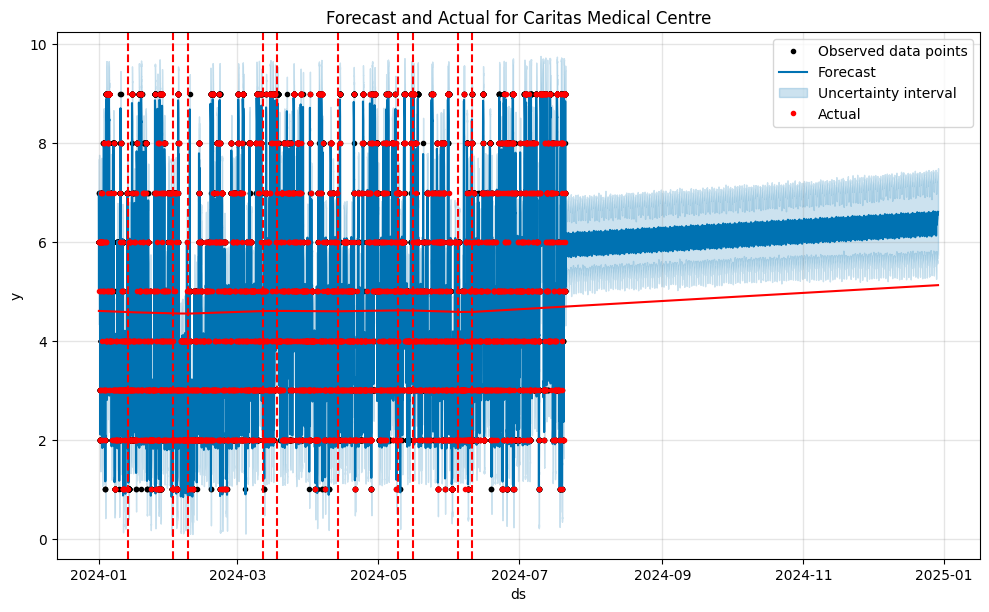

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 9 9 ... 6 6 6]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

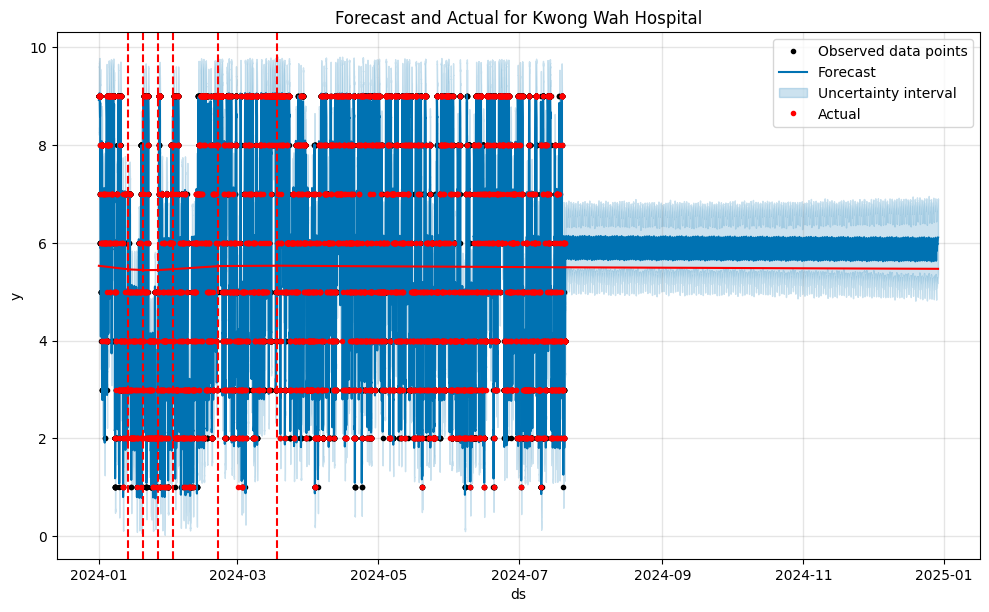

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 9 9 ... 6 6 7]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:41:16 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

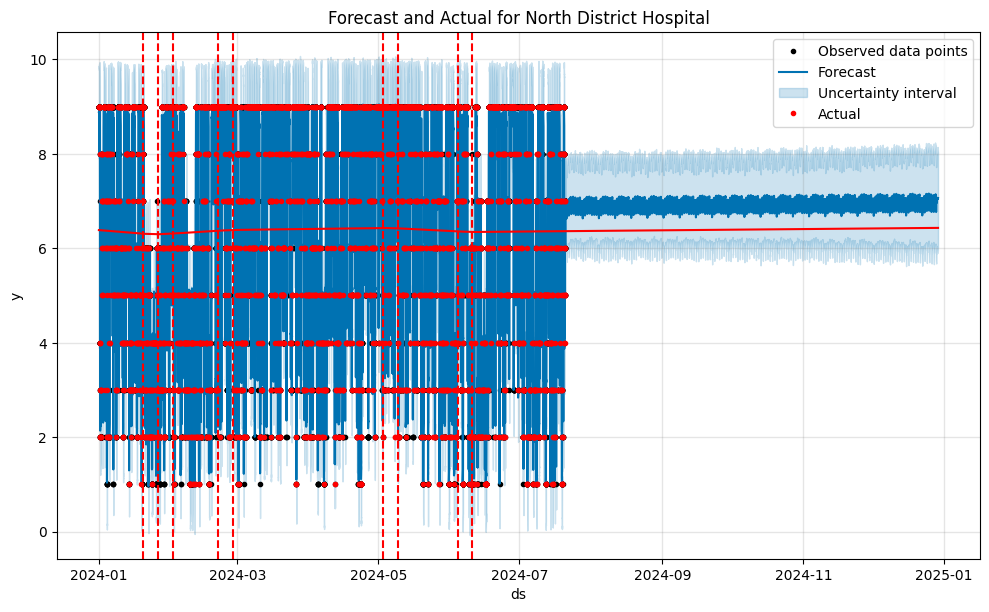

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 5 5 ... 2 2 2]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:41:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

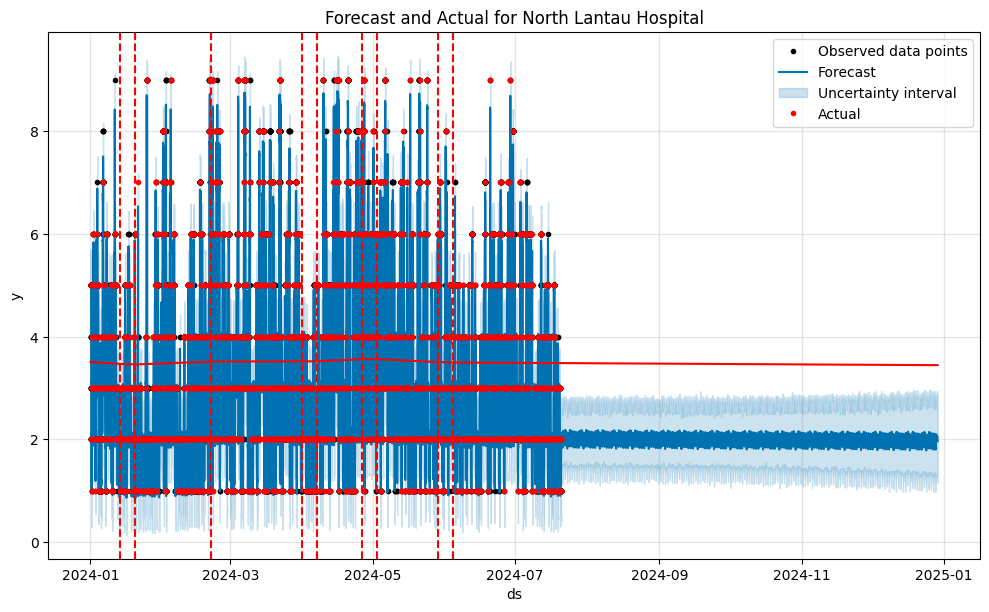

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 9 9 ... 6 6 6]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:41:33 - cmdstanpy - INFO - Chain [1] start processing
12:41:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

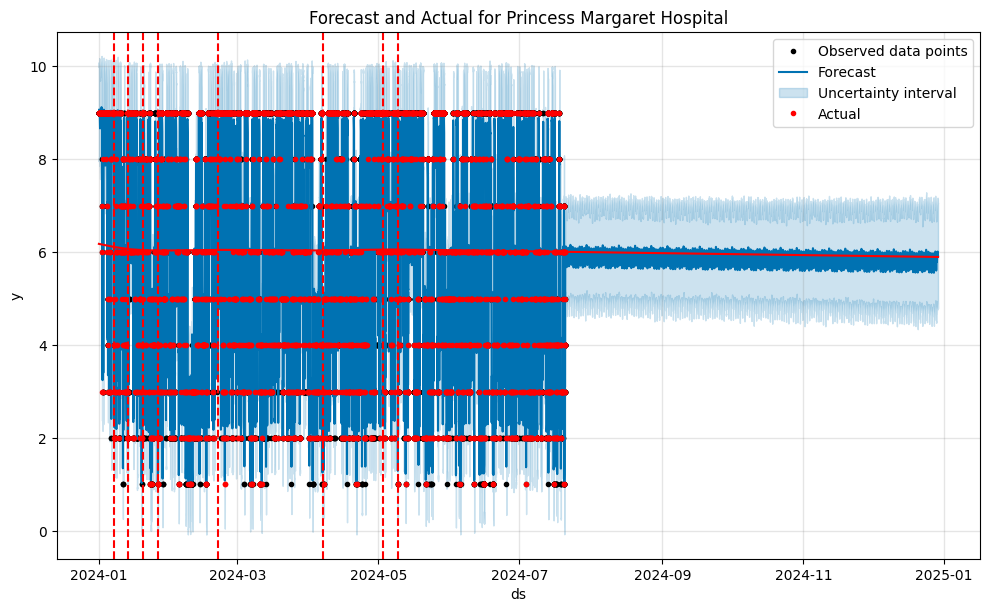

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 6 6 ... 6 6 6]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:41:39 - cmdstanpy - INFO - Chain [1] start processing
12:41:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

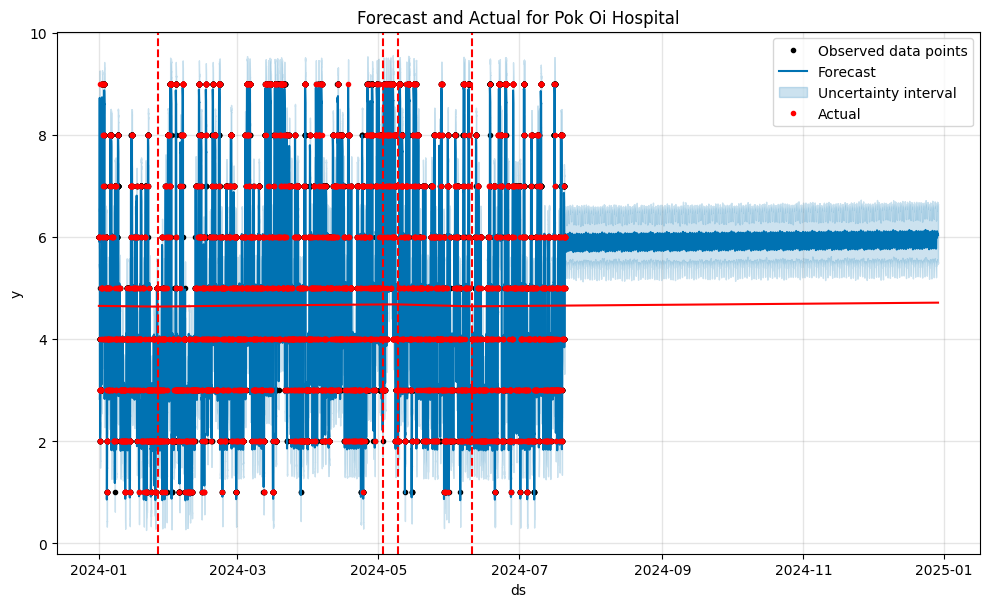

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 6 5 ... 4 4 4]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

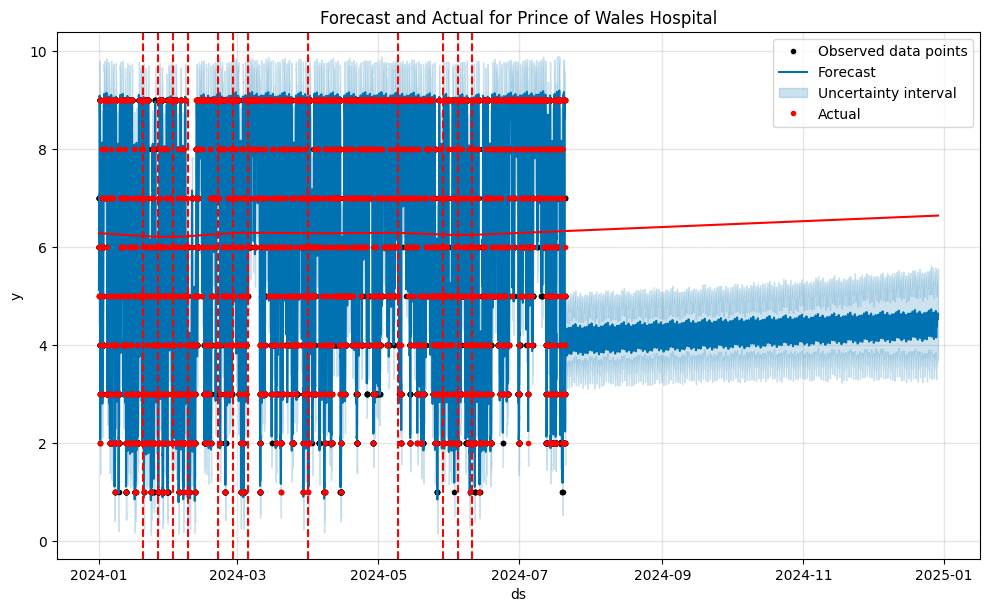

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 5 5 ... 5 5 5]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

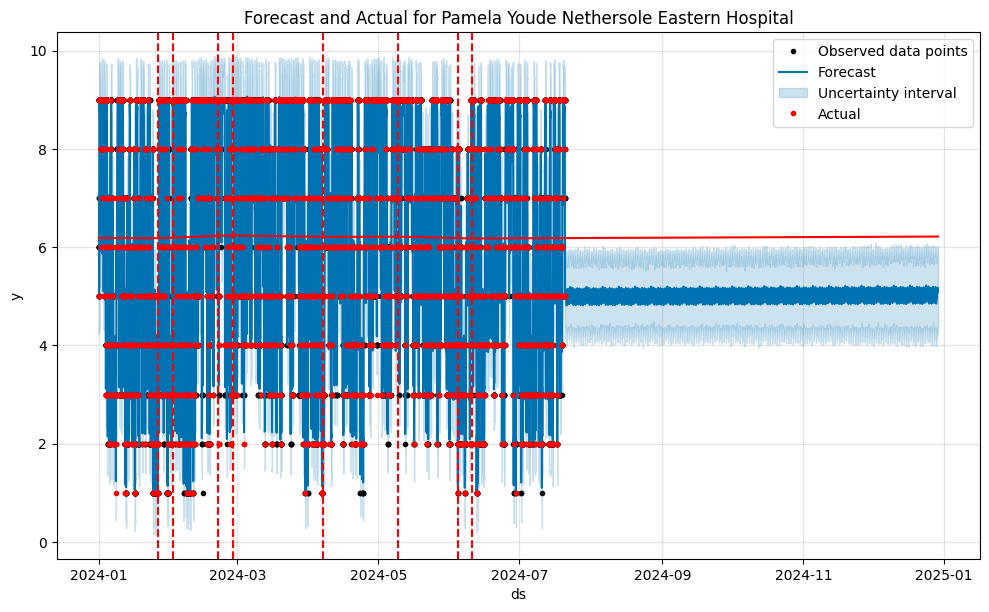

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 3 2 ... 2 3 3]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:42:01 - cmdstanpy - INFO - Chain [1] start processing
12:42:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

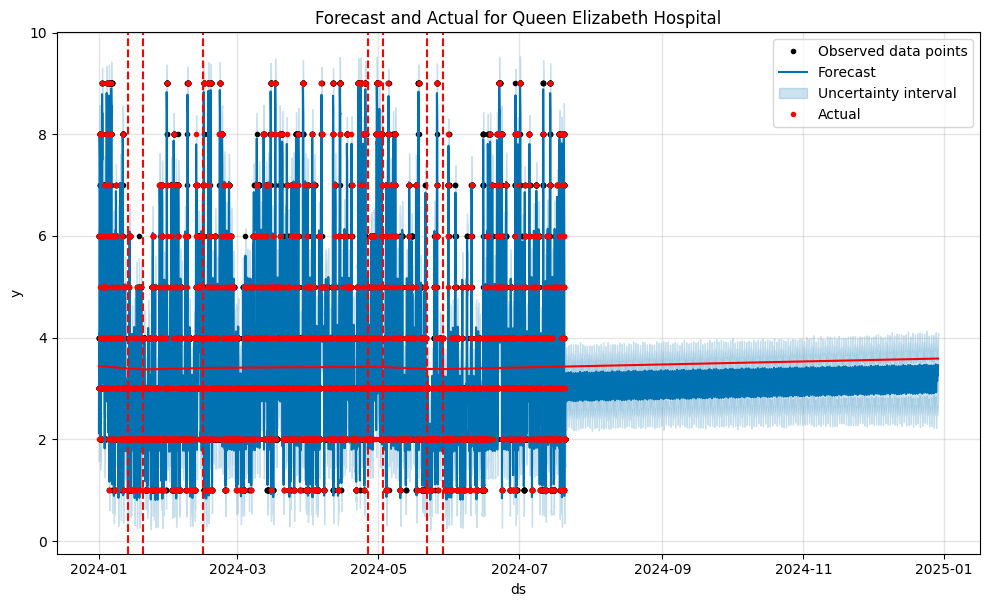

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 6 6 ... 6 6 6]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

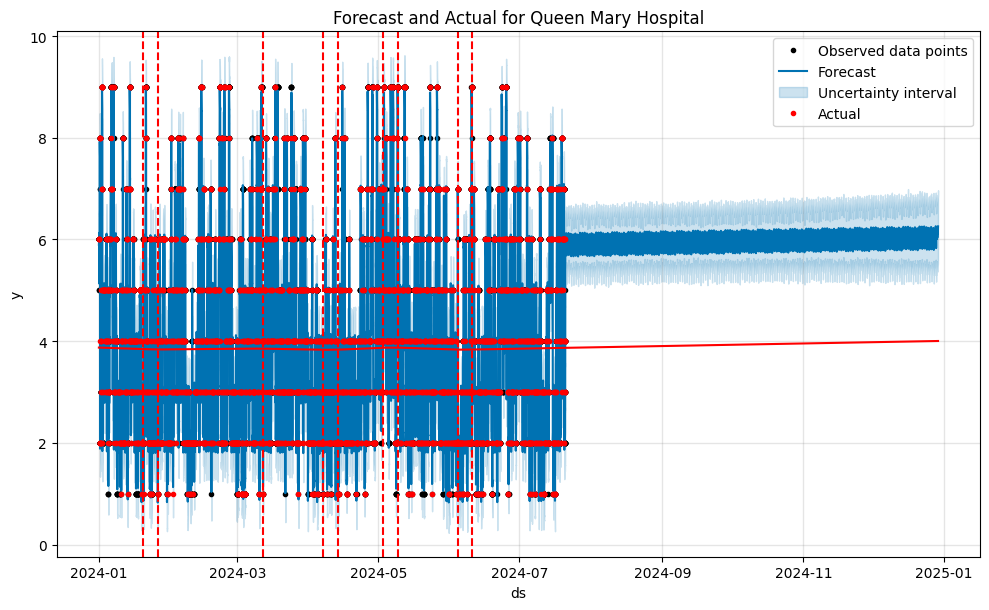

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 5 5 ... 6 6 6]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

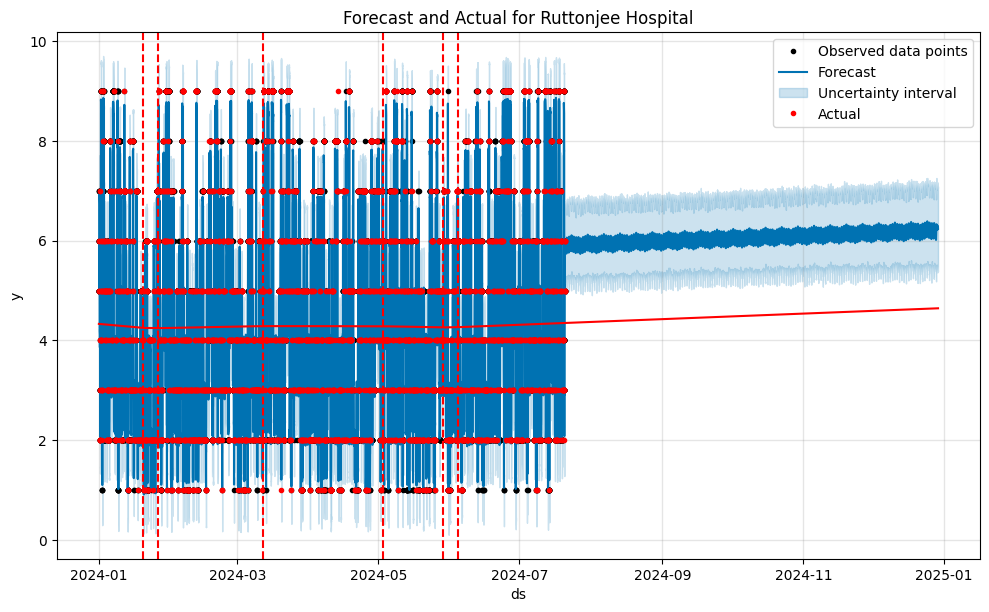

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 1 1 ... 1 1 1]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:42:28 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

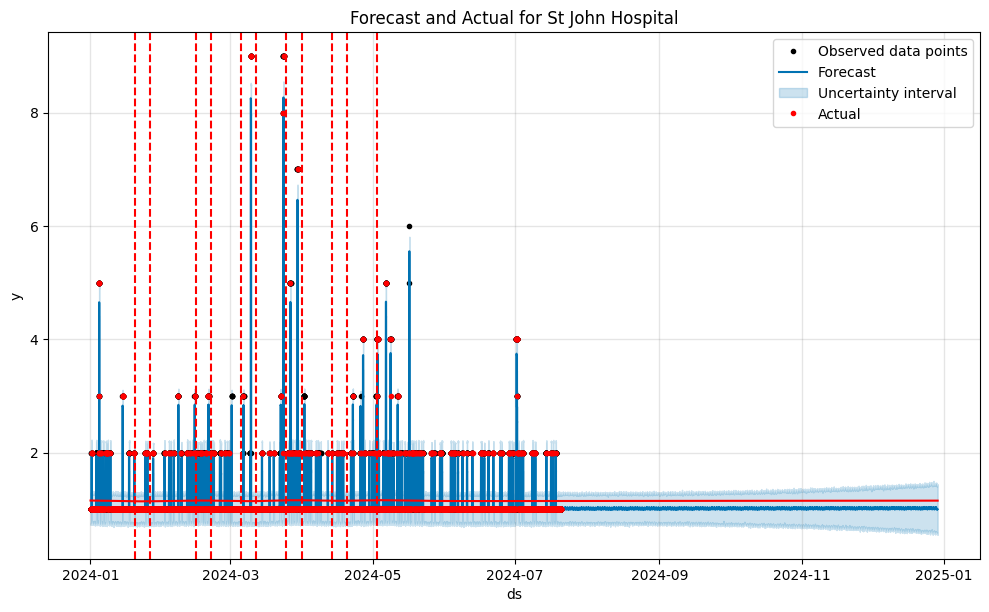

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 6 6 ... 5 5 5]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

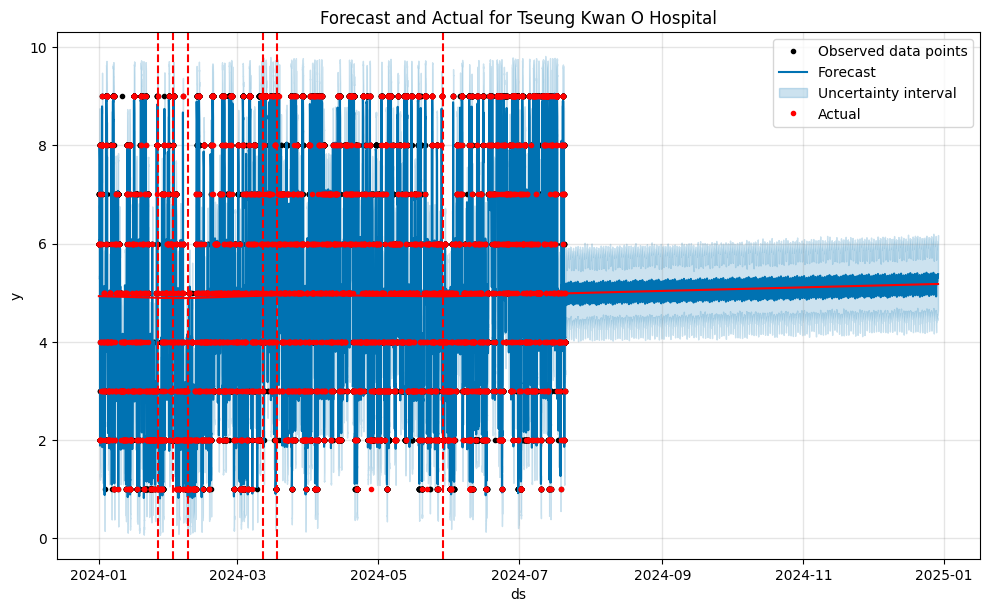

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 9 9 ... 4 4 5]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:42:43 - cmdstanpy - INFO - Chain [1] start processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

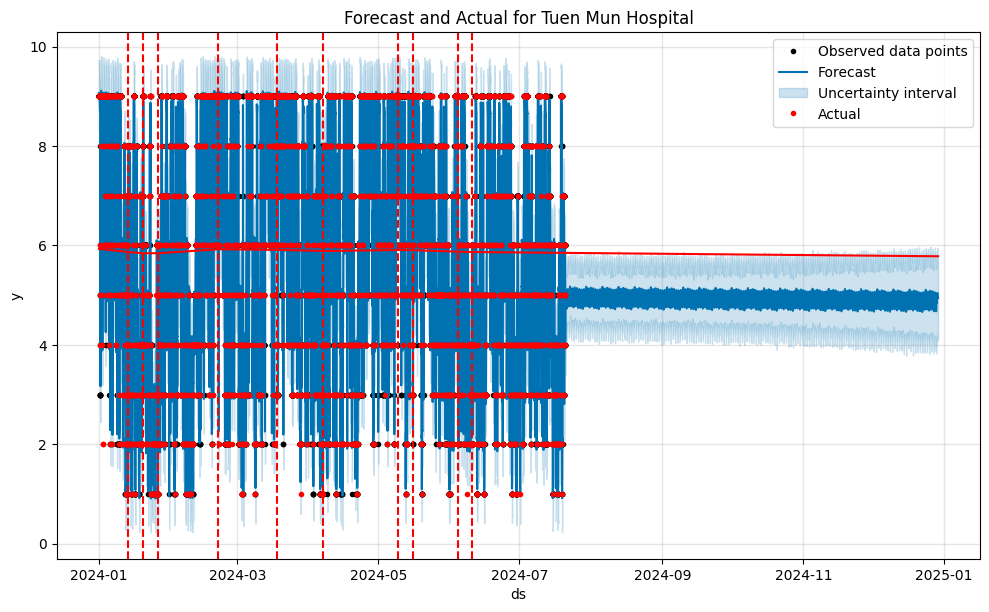

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 4 4 ... 2 2 2]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:42:52 - cmdstanpy - INFO - Chain [1] start processing
12:42:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

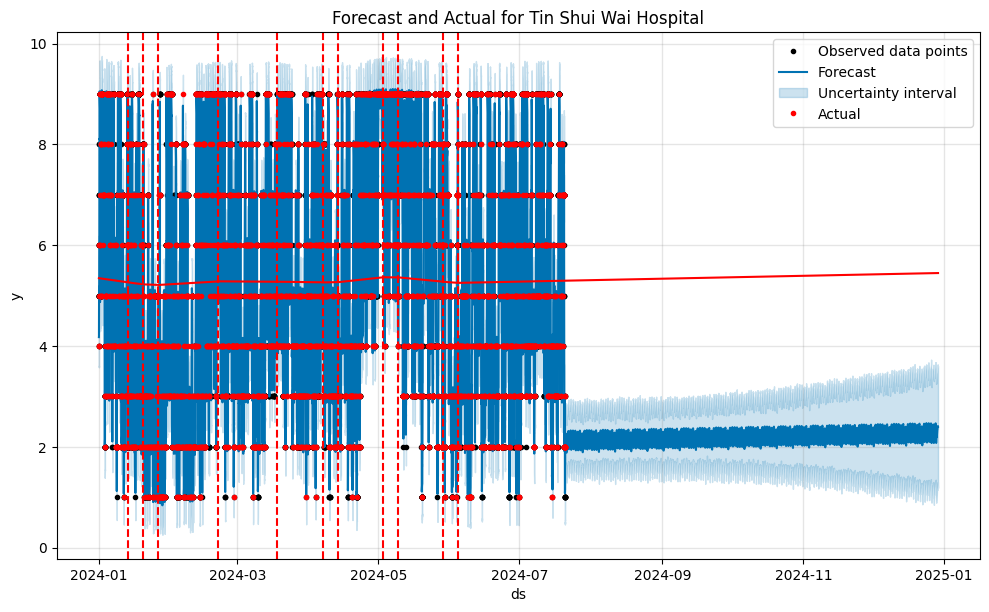

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 8 8 ... 3 3 3]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:43:00 - cmdstanpy - INFO - Chain [1] start processing
12:43:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

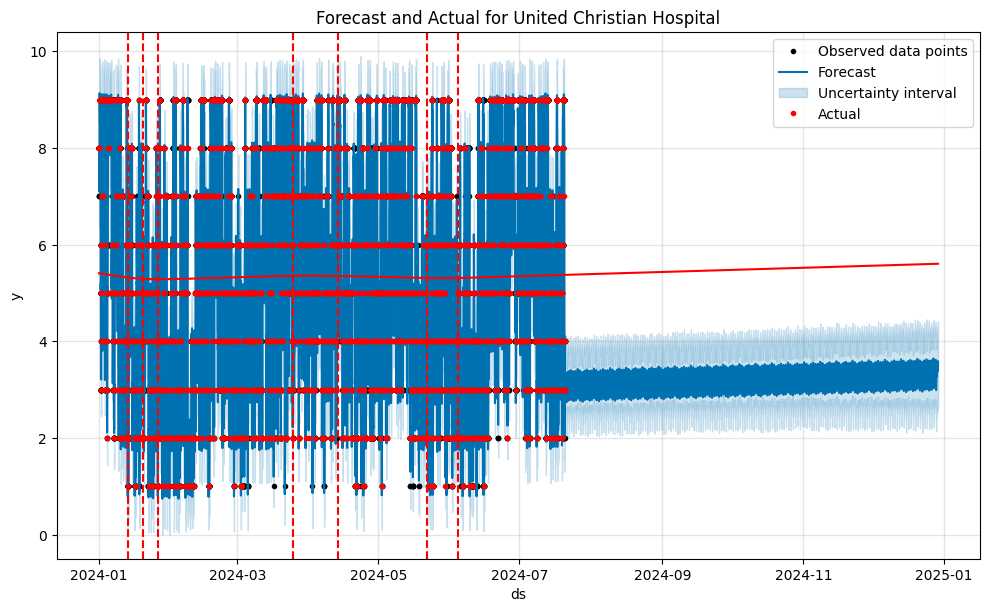

C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None 7 7 ... 4 4 4]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
12:43:08 - cmdstanpy - INFO - Chain [1] start processing
12:43:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\PC\AppData\Local\Temp\ipykernel_14188\213995740.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['previous wait'] = future['previous wait'].ffill()
C:\Users\PC\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of Date

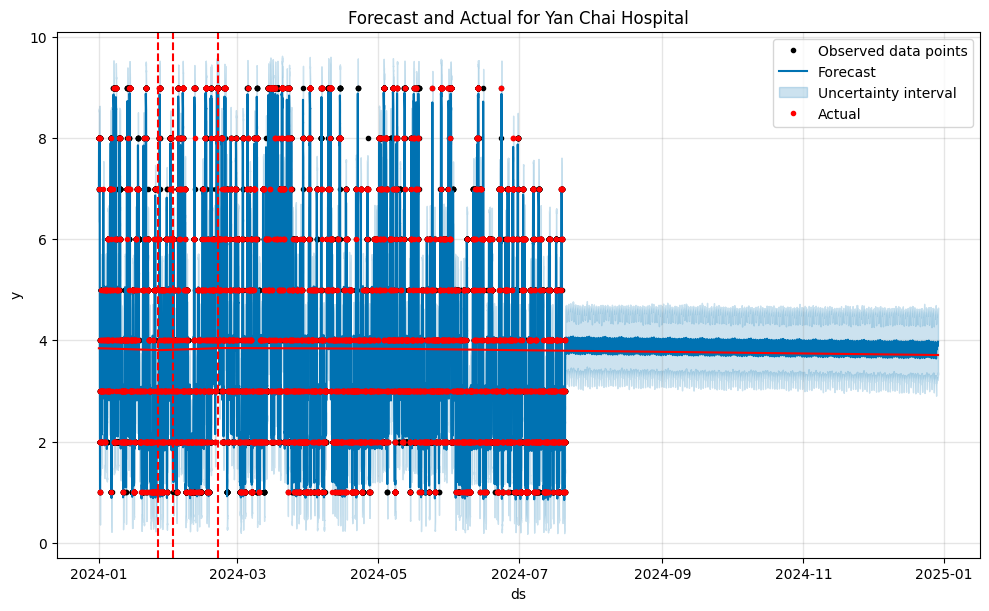

In [12]:
# Loop through each hospital and fit a model
for hospital in hospitals:
    # Filter and copy the DataFrame for the current hospital
    temp_df = reformatted_data[reformatted_data['hospital'] == hospital].copy()
    
    # Ensure 'timestamp' column is present and rename it to 'ds'
    if 'timestamp' in temp_df.columns:
        temp_df.rename(columns={'timestamp': 'ds'}, inplace=True)
    else:
        print("Error: 'timestamp' column not found in temp_df")
        continue
    
    temp_df.loc[:, 'previous wait'] = temp_df['current wait'].shift(1)  # Safe assignment
    
    if 'ds' in temp_df.columns and 'current wait' in temp_df.columns:
        prophet_df = temp_df[['ds', 'current wait', 'previous wait']].rename(columns={'current wait': 'y'})
        prophet_df.dropna(inplace=True)
    else:
        print("Error: Required columns are missing")
        continue
    
    train_df, test_df = train_test_split(prophet_df, test_size=0.2, random_state=42)
    
    m = Prophet()
    m.add_regressor('previous wait')
    m.fit(train_df)
    
    models[hospital] = m
    
    future = m.make_future_dataframe(periods=len(test_df), include_history=True, freq='h')  # Changed 'H' to 'h'
    future = future.merge(temp_df[['ds', 'previous wait']], on='ds', how='left')
    
    # Using .ffill() directly
    future['previous wait'] = future['previous wait'].ffill()

    forecast = m.predict(future)
    forecasts[hospital] = forecast
    
    fig = m.plot(forecast)
    add_changepoints_to_plot(fig.gca(), m, forecast)
    plt.title(f"Forecast and Actual for {hospital}")
    plt.plot(test_df['ds'], test_df['y'], 'r.', label='Actual')
    plt.legend()
    plt.show()

# Saving the model

In [14]:
import pickle
import os

In [15]:
# Ensure the directory for models exists
models_directory = '../models'
os.makedirs(models_directory, exist_ok=True)

In [17]:
# Loop through each hospital and save the model
for hospital in hospitals:
    # Replace spaces with underscores, convert to lowercase, and handle other potential filename issues
    filename = f"{hospital.replace(' ', '_').lower()}.pckl"
    filepath = os.path.join(models_directory, filename)
    
    # Serialize the model to a file
    with open(filepath, 'wb') as fout:
        pickle.dump(models[hospital], fout)